In [62]:
#!/usr/bin/env python
# coding: utf-8

# In[52]:

print("Please Work")
import json
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score
from PIL import Image
import random
import torch
from torch import autograd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
output_dir = '/home-mscluster/glaxton/TIL'
print("Imports loaded")

# Define the transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load and transform the datasets
transform = transforms.Compose([transforms.ToTensor()])

# Standard MNIST for Task A (Digit Classification)
train_A_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_A_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Function to create a balanced subset
def create_balanced_subset(dataset, num_samples_per_class):
    class_indices = {i: [] for i in range(10)}  # Store indices for each class (0-9)

    # Sort dataset into classes
    for idx, (_, target) in enumerate(dataset):
        class_indices[target].append(idx)

    # Randomly select num_samples_per_class indices per class
    subset_indices = []
    for class_label, indices in class_indices.items():
        subset_indices.extend(np.random.choice(indices, num_samples_per_class, replace=False))

    # Create the subset
    subset = Subset(dataset, subset_indices)
    return subset

# Create a subset with 100 samples per digit
train_A_dataset = create_balanced_subset(train_A_dataset, num_samples_per_class=1500)
test_A_dataset = create_balanced_subset(test_A_dataset, num_samples_per_class=150)



# Custom dataset for Task B (Even-Odd Classification)
class EvenOddMNIST(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        img, target = self.mnist_dataset[index]
        even_odd_target = target % 2  # 0 for even, 1 for odd
        return img, even_odd_target

    def __len__(self):
        return len(self.mnist_dataset)

train_B_dataset = EvenOddMNIST(train_A_dataset)
test_B_dataset = EvenOddMNIST(test_A_dataset)

class TaskIdentifierDataset(Dataset):
    def __init__(self, dataset, task_id):
        self.dataset = dataset
        self.task_id = task_id

    def __getitem__(self, index):
        img, target = self.dataset[index]
        task_identifier = torch.tensor([self.task_id], dtype=torch.float32)
        return img, target, task_identifier

    def __len__(self):
        return len(self.dataset)

# Wrapping the original datasets with task identifiers
train_A_dataset_with_id = TaskIdentifierDataset(train_A_dataset, 1.0)
test_A_dataset_with_id = TaskIdentifierDataset(test_A_dataset, 1.0)
train_B_dataset_with_id = TaskIdentifierDataset(train_B_dataset, 0.0)
test_B_dataset_with_id = TaskIdentifierDataset(test_B_dataset, 0.0)

# Split into training and validation sets for Task A and Task B
train_size_A = int(0.8 * len(train_A_dataset_with_id))  # 80% for training
val_size_A = len(train_A_dataset_with_id) - train_size_A  # 20% for validation

train_size_B = int(0.8 * len(train_B_dataset_with_id))  # 80% for training
val_size_B = len(train_B_dataset_with_id) - train_size_B  # 20% for validation

train_A_dataset_with_id, val_A_dataset_with_id = random_split(train_A_dataset_with_id, [train_size_A, val_size_A])
train_B_dataset_with_id, val_B_dataset_with_id = random_split(train_B_dataset_with_id, [train_size_B, val_size_B])

# Create DataLoaders
train_A_loader = DataLoader(train_A_dataset_with_id, batch_size=64, shuffle=True)
val_A_loader = DataLoader(val_A_dataset_with_id, batch_size=64, shuffle=False)
test_A_loader = DataLoader(test_A_dataset_with_id, batch_size=64, shuffle=False)

train_B_loader = DataLoader(train_B_dataset_with_id, batch_size=64, shuffle=True)
val_B_loader = DataLoader(val_B_dataset_with_id, batch_size=64, shuffle=False)
test_B_loader = DataLoader(test_B_dataset_with_id, batch_size=64, shuffle=False)

Please Work
Imports loaded


In [63]:
class ConvNet(nn.Module):
    def __init__(self, shared_dim=128, output_dim_A=10, output_dim_B=2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28 + 1, shared_dim)  # Adjusted to match the output size after conv layers + task identifier
        self.fc2_A = nn.Linear(shared_dim, output_dim_A)
        self.fc2_B = nn.Linear(shared_dim, output_dim_B)

    def forward(self, x, task_id):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        task_id = task_id.view(-1, 1)  # Ensure task_id has shape (batch_size, 1)
        x = torch.cat((x, task_id), dim=1)  # Concatenate task identifier
        x = F.relu(self.fc1(x))

        # Generate outputs for both tasks
        output_A = self.fc2_A(x)
        output_B = self.fc2_B(x)

        # Combine the outputs into a single tensor with proper shape
        output = torch.zeros(x.size(0), max(output_A.size(1), output_B.size(1)), device=x.device)
        output[:, :output_A.size(1)] = output_A * (task_id == 1).float()
        output[:, :output_B.size(1)] += output_B * (task_id == 0).float()

        return output


# Training function
def train(model, loader, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for data, target, task_id in loader:  # Ensure the DataLoader returns three items
            optimizer.zero_grad()
            output = model(data, task_id)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(loader)}')

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target, task_id in loader:  # Ensure the DataLoader returns three items
            output = model(data, task_id)
            loss = criterion(output, target)
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    return accuracy, precision, recall, kappa


# In[55]:


def train_with_patience(model, loader, optimizer, criterion, epochs=20, patience=5):
    model.train()
    best_loss = float('inf')
    no_improvement = 0
    epoch_accuracy = []
    epochs_loss = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        for data, target, task_id in loader:  # Ensure the DataLoader returns three items
            optimizer.zero_grad()
            output = model(data, task_id)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        avg_loss = epoch_loss / len(loader)
        accuracy = correct / total
        epoch_accuracy.append(accuracy)
        epochs_loss.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

        # Check for improvement
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improvement = 0
        else:
            no_improvement += 1

        # Early stopping criteria
        if no_improvement >= patience:
            print(f"Stopping early due to no improvement in loss for {patience} consecutive epochs.")
            break

    return epoch_accuracy, epochs_loss


# In[56]:


import torch
from torch import autograd

class EWC:
    def __init__(self, model, dataloader, importance=10000):
        self.model = model
        self.dataloader = dataloader
        self.importance = importance
        self.initial_params = {n: p.clone() for n, p in self.model.named_parameters()}
        self.fisher_diagonal = self.compute_fisher_information()

    def compute_fisher_information(self):
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}
        mean_fisher = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}
        self.model.eval()
        
        for i, (data, target, task_id) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data, task_id)
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()
            
            for n, p in self.model.named_parameters():
                grad_squared = p.grad ** 2
                
                # Apply the formula for online mean calculation
                fisher_diagonal[n] = fisher_diagonal[n] + (grad_squared - fisher_diagonal[n]) / i
    
        return fisher_diagonal

    def penalty(self):
        penalty = 0
        for n, p in self.model.named_parameters():
            penalty += (self.fisher_diagonal[n] * (p - self.initial_params[n]) ** 2).sum()
        return self.importance * penalty




# In[57]:


def train_with_ewc(model, loader, ewc, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0
        for data, target, task_id in loader:
            optimizer.zero_grad()
            output = model(data, task_id)
            loss = criterion(output, target)
            penalty = ewc.penalty()
            total_loss += loss.item()
            total_penalty += penalty.item()
            loss += penalty
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}, Penalty: {total_penalty / len(loader):.4f}')


# In[58]:


def train_with_ewc_with_patience(model, loader, ewc, optimizer, criterion, epochs=20, patience=5):
    model.train()
    best_loss = float('inf')
    no_improvement = 0
    epoch_accuracy = []
    epochs_loss = []

    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0
        total = 0
        correct = 0
        for data, target, task_id in loader:
            optimizer.zero_grad()
            output = model(data, task_id)
            loss = criterion(output, target)
            penalty = ewc.penalty()
            total_loss += loss.item()
            total_penalty += penalty.item()
            loss += penalty
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        avg_loss = total_loss / len(loader)
        avg_penalty = total_penalty / len(loader)
        accuracy = correct / total
        epoch_accuracy.append(accuracy)
        epochs_loss.append(avg_loss)
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}')

        # Check for improvement
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improvement = 0
        else:
            no_improvement += 1

        # Early stopping criteria
        if no_improvement >= patience:
            print(f"Stopping early due to no improvement in loss for {patience} consecutive epochs.")
            break


    return epoch_accuracy, epochs_loss


# In[59]:


class SynapticIntelligence:
    def __init__(self, model, dataloader, importance=1000, device='cpu'):
        self.model = model
        self.dataloader = dataloader
        self.importance = importance
        self.device = device
        self.saved_params = {}
        self.omega = {}

        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.saved_params[n] = p.clone().detach().to(self.device)
                self.omega[n] = torch.zeros_like(p).to(self.device)

    def update_omega(self, batch_loss, lr):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                if p.grad is not None:
                    self.omega[n] += p.grad * (p.detach() - self.saved_params[n])
                    self.saved_params[n] = p.clone().detach()

    def penalty(self):
        loss = 0
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                _loss = self.omega[n] * (p - self.saved_params[n]) ** 2
                loss += _loss.sum()
        return self.importance * loss

    def end_task(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.omega[n] /= len(self.dataloader)


# In[60]:


def train_with_si(model, loader, si, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target, task_id in loader:
            optimizer.zero_grad()
            output = model(data, task_id)
            loss = criterion(output, target)
            loss += si.penalty()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            si.update_omega(loss, optimizer.param_groups[0]['lr'])
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}')
    si.end_task()


# In[61]:


class RehearsalBuffer:
    def __init__(self, buffer_size=200):
        self.buffer_size = buffer_size
        self.buffer = []

    def add_to_buffer(self, data, target, task_id):
        for i in range(len(data)):
            if len(self.buffer) >= self.buffer_size:
                self.buffer.pop(0)
            self.buffer.append((data[i], target[i], task_id[i]))

    def get_buffer(self):
        data, target, task_id = zip(*self.buffer)
        return torch.stack(data), torch.tensor(target), torch.tensor(task_id)


# In[62]:


def train_with_rehearsal(model, loader, buffer, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target, task_id in loader:
            buffer.add_to_buffer(data, target, task_id)
            optimizer.zero_grad()
            output = model(data, task_id)
            loss = criterion(output, target)
            if len(buffer.buffer) > 0:
                buffer_data, buffer_target, buffer_task_id = buffer.get_buffer()
                buffer_output = model(buffer_data, buffer_task_id)
                loss += criterion(buffer_output, buffer_target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}')


# In[63]:


class PNN(nn.Module):
    def __init__(self, shared_dim=128, output_dim_A=10, output_dim_B=2):
        super(PNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1_A = nn.Linear(64 * 28 * 28, shared_dim)
        self.fc2_A = nn.Linear(shared_dim, output_dim_A)
        self.fc1_B = nn.Linear(64 * 28 * 28, shared_dim)
        self.fc2_B = nn.Linear(shared_dim, output_dim_B)

    def forward(self, x, task_id):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        if task_id[0] == 1:
            x = F.relu(self.fc1_A(x))
            output = self.fc2_A(x)
        else:
            x = F.relu(self.fc1_B(x))
            output = self.fc2_B(x)
        return output


# In[64]:


def train_pnn(model, loader, optimizer, criterion, task_num, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target, task_id in loader:
            optimizer.zero_grad()
            output = model(data, task_id)
            loss = criterion(output, target)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}')

def evaluate_pnn(model, loader, criterion, task_num):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target, task_id in loader:
            output = model(data, task_id)
            loss = criterion(output, target)
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    return accuracy, precision, recall, kappa

In [64]:
epoch_stats_other = {
    "si": {"acc_B": [], "loss_B": [], "task_A_during_B":[],"task_A_during_B_loss":[],"val_task_A_during_B":[],"val_acc_B":[]},
    "pnn": {"acc_B": [], "loss_B": [], "task_A_during_B":[],"task_A_during_B_loss":[],"val_task_A_during_B":[],"val_acc_B":[]},
    "reh": {"acc_B": [], "loss_B": [], "task_A_during_B":[],"task_A_during_B_loss":[],"val_task_A_during_B":[],"val_acc_B":[]}
}

num_runs = 1
epochs = 50


# In[72]:


# Initialize models, optimizers, and criteria
shared_dim = 128
output_dim_A = 10
output_dim_B = 2
lr = 0.0000

In [ ]:
# Initialize the model for Task A
modelA = ConvNet(shared_dim=128, output_dim_A=10, output_dim_B=2)
optimizerA = optim.Adam(modelA.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Evaluate "Untrained_A" - performance on Task A before any training
accuracy_untrained_A, precision_untrained_A, recall_untrained_A, kappa_untrained_A = evaluate(modelA, test_A_loader, criterion)
print(f"Task A - Untrained: Accuracy: {accuracy_untrained_A}, Precision: {precision_untrained_A}, Recall: {recall_untrained_A}, Kappa: {kappa_untrained_A}")
results["untrained_A"]["accuracy"].append(accuracy_untrained_A)
results["untrained_A"]["precision"].append(precision_untrained_A)
results["untrained_A"]["recall"].append(recall_untrained_A)
results["untrained_A"]["kappa"].append(kappa_untrained_A)

task_B_during_A = []
task_A_during_A = []

task_B_during_A_val = []
task_A_during_A_val = []

# Train model on Task A (digit classification)
for epoch in range(epochs):
    acc_A, loss_A = train_with_patience(modelA, train_A_loader, optimizerA, criterion, epochs = 1, patience=100)

    # Track performance on Task B
    accuracy_taskA_during_A, _, _, _ = evaluate(modelA, test_A_loader, criterion)
    print(f"Epoch {epoch + 1} - Task A during A (with EWC): {accuracy_taskA_during_A:.4f}")
    task_A_during_A.append(accuracy_taskA_during_A)

    accuracy_taskA_during_A_val, _, _, _ = evaluate(modelA, val_A_loader, criterion)
    print(f"Epoch {epoch + 1} - Task A during A (with EWC): {accuracy_taskA_during_A_val:.4f}")
    task_A_during_A_val.append(accuracy_taskA_during_A_val)

    # Track performance on Task B
    accuracy_taskB_during_A, _, _, _ = evaluate(modelA, test_B_loader, criterion)
    print(f"Epoch {epoch + 1} - Task B during A (with EWC): {accuracy_taskB_during_A:.4f}")
    task_B_during_A.append(accuracy_taskB_during_A)

    # Track performance on Task B
    accuracy_taskB_during_A_val, _, _, _ = evaluate(modelA, val_B_loader, criterion)
    print(f"Epoch {epoch + 1} - Task B during A (with EWC): {accuracy_taskB_during_A_val:.4f}")
    task_B_during_A_val.append(accuracy_taskB_during_A_val)


torch.save(modelA.state_dict(), 'taskA_model.pth')

In [65]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define lambda variations (±1%, ±2%, ±5%, ±10%)
baseline_lambda = 99999999999999999  # Example baseline value
lambda_variations = [1.01, 0.99, 1.02, 0.98, 1.05, 0.95, 1.10, 0.90]  
lambda_values = [baseline_lambda] + [int(baseline_lambda * factor) for factor in lambda_variations]

# Initialize storage for each lambda configuration
epoch_stats = {f"ewc_lambda_{lam}": {"task_A_during_B": [], "task_B": [], "task_A": []} for lam in lambda_values}

epochs = 2
num_runs = 1  # Each lambda value gets 10 trials
learning_rate = 0.00001

for lambda_ewc in lambda_values:
    print(f"Running EWC with lambda_ewc = {lambda_ewc}")

    for run in range(num_runs):
        print(f"  Run {run + 1}/{num_runs}")

        # Initialize model and optimizer
        modelA = ConvNet(shared_dim=128, output_dim_A=10, output_dim_B=2)
        optimizerA = optim.Adam(modelA.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Initialize lists for per-epoch tracking
        task_A_ewc_run, task_B_ewc_run, task_A_during_B_ewc_run = [], [], []

        modelA.load_state_dict(torch.load('taskA_model.pth'))

        # Store Task A training results
        epoch_stats[f"ewc_lambda_{lambda_ewc}"]["task_A"].append(task_A_ewc_run)

        # Initialize EWC and update Fisher Information
        ewc = EWC(modelA, train_A_loader, importance=lambda_ewc)

        # Train on Task B with EWC
        for epoch in range(epochs):
            train_with_ewc_with_patience(modelA, train_B_loader, ewc, optimizerA, criterion, epochs=1, patience=20)
            acc_B = evaluate(modelA, test_B_loader, criterion)[0]  
            acc_A_during_B = evaluate(modelA, test_A_loader, criterion)[0]  

            task_B_ewc_run.append(acc_B)
            task_A_during_B_ewc_run.append(acc_A_during_B)

        # Store Task B results
        epoch_stats[f"ewc_lambda_{lambda_ewc}"]["task_B"].append(task_B_ewc_run)
        epoch_stats[f"ewc_lambda_{lambda_ewc}"]["task_A_during_B"].append(task_A_during_B_ewc_run)



Running EWC with lambda_ewc = 99999999999999999
  Run 1/1
Epoch 1/1, Loss: 1.9578
Epoch 1/1, Loss: 1.0558
Epoch 1/1, Loss: 2.1266, Penalty: 1934809442.3936
Epoch 1/1, Loss: 1.7678, Penalty: 2101796266.2128
Running EWC with lambda_ewc = 101000000000000000
  Run 1/1
Epoch 1/1, Loss: 1.8812
Epoch 1/1, Loss: 0.9897
Epoch 1/1, Loss: 1.8175, Penalty: 2014762321.6596
Epoch 1/1, Loss: 1.4151, Penalty: 2188680467.0638
Running EWC with lambda_ewc = 99000000000000000
  Run 1/1
Epoch 1/1, Loss: 1.9173
Epoch 1/1, Loss: 0.9843
Epoch 1/1, Loss: 1.6416, Penalty: 2202172744.2979
Epoch 1/1, Loss: 1.3879, Penalty: 2392430058.2128
Running EWC with lambda_ewc = 102000000000000000
  Run 1/1
Epoch 1/1, Loss: 1.9670
Epoch 1/1, Loss: 1.0807
Epoch 1/1, Loss: 1.7187, Penalty: 2869375893.7979
Epoch 1/1, Loss: 1.4165, Penalty: 3117657259.5745
Running EWC with lambda_ewc = 98000000000000000
  Run 1/1
Epoch 1/1, Loss: 1.9992
Epoch 1/1, Loss: 1.1521
Epoch 1/1, Loss: 1.4833, Penalty: 2368747502.5745
Epoch 1/1, Loss: 1

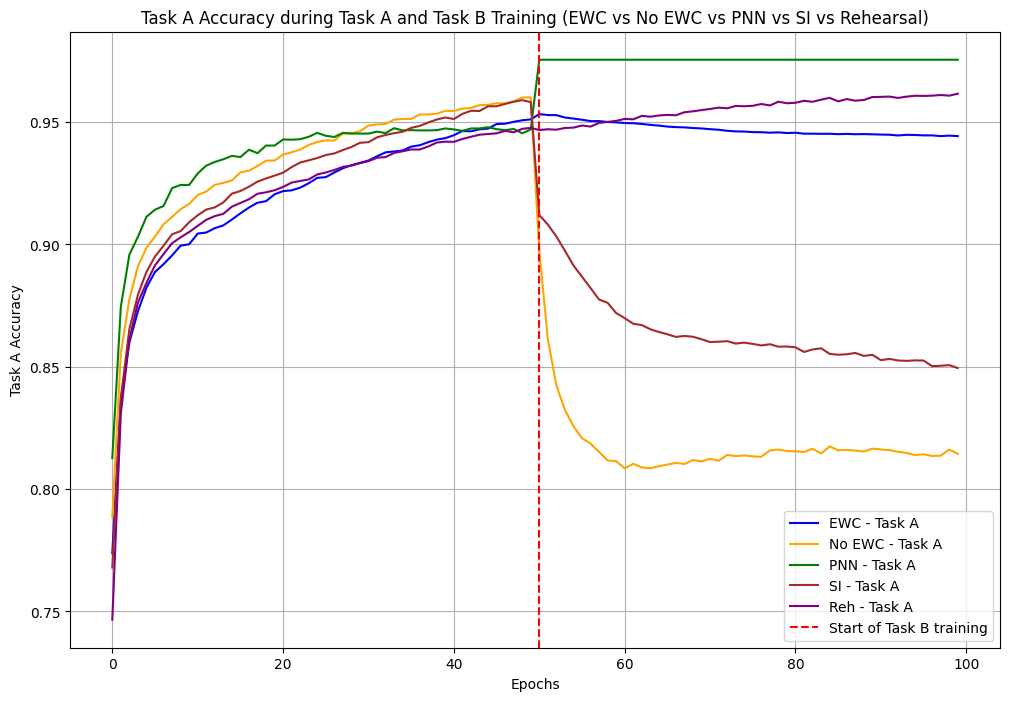

In [51]:
import matplotlib.pyplot as plt
import numpy as np
# Calculate the mean for Task A during Task A and Task B across all runs
ewc_initial_acc = np.mean(epoch_stats_5_test["Initial"]["A_during_A_val"], axis=0)  # Mean across runs
no_ewc_initial_acc = np.mean(epoch_stats_final["Initial"]["A_during_A_val"], axis=0)  # Same for No EWC
pnn_A_during_A = np.mean(epoch_stats_other_pnn_A["pnn"]["A_during_A"], axis=0)
si_A_during_A = np.mean(epoch_stats_other_si_combined["si"]["A_during_A_val"], axis=0)
reh_A_during_A = np.mean(epoch_stats_other_reh_combined["reh"]["A_during_A_val"], axis=0)

# Now for Task A accuracy during Task B training
ewc_task_A_during_B = np.mean(epoch_stats_5_test["ewc"]["val_task_A_during_B"], axis=0)  # Average over runs
no_ewc_task_A_during_B = np.mean(epoch_stats_final["no_ewc"]["val_task_A_during_B"], axis=0)  # Same for No EWC
pnn_task_A_during_B = np.mean(epoch_stats_other_pnn["pnn"]["val_task_A_during_B"],axis = 0) # Same for pnn
si_task_A_during_B = np.mean(epoch_stats_other_si_combined["si"]["val_task_A_during_B"],axis=0) # Same for si
reh_task_A_during_B = np.mean(epoch_stats_other_reh_combined["reh"]["val_task_A_during_B"],axis=0) # Same for reh

#no_ewc_task_A_during_B = no_ewc_task_A_during_B[:50]
pnn_task_A_during_B = pnn_task_A_during_B[:50]


# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B])
no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B])
pnn_task_A_combined = np.concatenate([pnn_A_during_A, pnn_task_A_during_B])
si_task_A_combined = np.concatenate([si_A_during_A, si_task_A_during_B])
reh_task_A_combined = np.concatenate([reh_A_during_A, reh_task_A_during_B])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(reh_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Task A', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Task A', color='orange')
plt.plot(x_values, pnn_task_A_combined, label='PNN - Task A', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Task A', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Task A', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(reh_A_during_A), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Task A Accuracy')
plt.title('Task A Accuracy during Task A and Task B Training (EWC vs No EWC vs PNN vs SI vs Rehearsal)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/TIL/Data/Bench/task_A_combined_accuracy_til_bench.png')
plt.show()


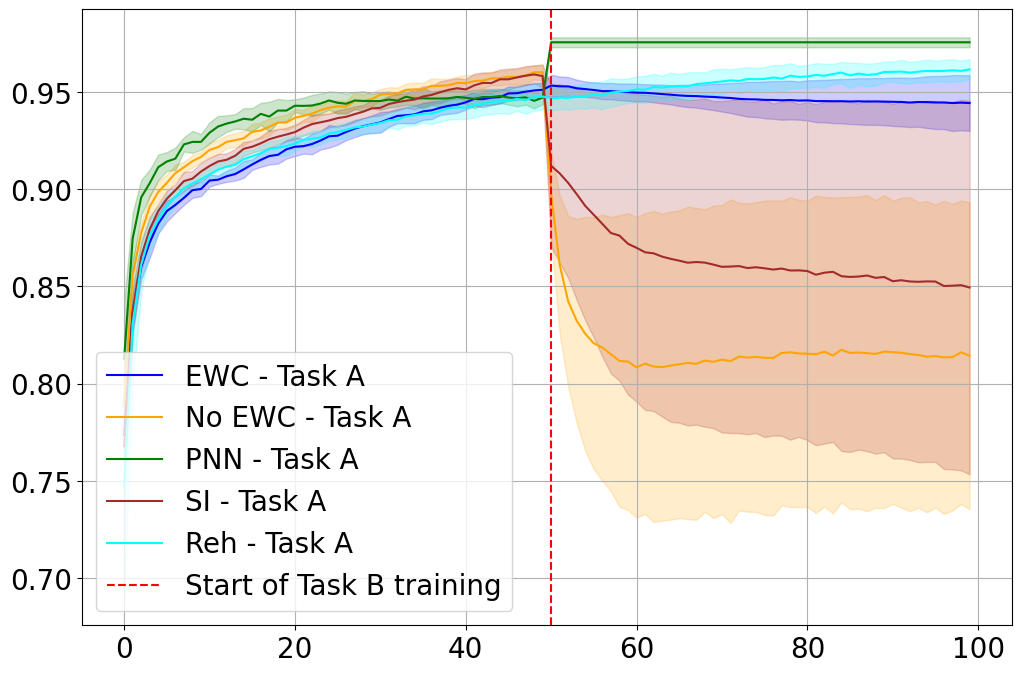

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean for Task A during Task A and Task B across all runs
ewc_initial_acc = np.mean(epoch_stats_5_test["Initial"]["A_during_A_val"], axis=0)
no_ewc_initial_acc = np.mean(epoch_stats_final["Initial"]["A_during_A_val"], axis=0)
pnn_A_during_A = np.mean(epoch_stats_other_pnn_A["pnn"]["A_during_A"], axis=0)
si_A_during_A = np.mean(epoch_stats_other_si_combined["si"]["A_during_A_val"], axis=0)
reh_A_during_A = np.mean(epoch_stats_other_reh_combined["reh"]["A_during_A_val"], axis=0)

# Calculate the standard deviation for variance bands
ewc_initial_acc_std = np.std(epoch_stats_5_test["Initial"]["A_during_A_val"], axis=0)
no_ewc_initial_acc_std = np.std(epoch_stats_final["Initial"]["A_during_A_val"], axis=0)
pnn_A_during_A_std = np.std(epoch_stats_other_pnn_A["pnn"]["A_during_A"], axis=0)
si_A_during_A_std = np.std(epoch_stats_other_si_combined["si"]["A_during_A_val"], axis=0)
reh_A_during_A_std = np.std(epoch_stats_other_reh_combined["reh"]["A_during_A_val"], axis=0)

# Now for Task A accuracy during Task B training
ewc_task_A_during_B = np.mean(epoch_stats_5_test["ewc"]["val_task_A_during_B"], axis=0)
no_ewc_task_A_during_B = np.mean(epoch_stats_final["no_ewc"]["val_task_A_during_B"], axis=0)
pnn_task_A_during_B = np.mean(epoch_stats_other_pnn["pnn"]["val_task_A_during_B"], axis=0)
si_task_A_during_B = np.mean(epoch_stats_other_si_combined["si"]["val_task_A_during_B"], axis=0)
reh_task_A_during_B = np.mean(epoch_stats_other_reh_combined["reh"]["val_task_A_during_B"], axis=0)

ewc_task_A_during_B_std = np.std(epoch_stats_5_test["ewc"]["val_task_A_during_B"], axis=0)
no_ewc_task_A_during_B_std = np.std(epoch_stats_final["no_ewc"]["val_task_A_during_B"], axis=0)
pnn_task_A_during_B_std = np.std(epoch_stats_other_pnn["pnn"]["val_task_A_during_B"], axis=0)
si_task_A_during_B_std = np.std(epoch_stats_other_si_combined["si"]["val_task_A_during_B"], axis=0)
reh_task_A_during_B_std = np.std(epoch_stats_other_reh_combined["reh"]["val_task_A_during_B"], axis=0)

# Adjust phase lengths
pnn_task_A_during_B = pnn_task_A_during_B[:50]
pnn_task_A_during_B_std = pnn_task_A_during_B_std[:50]

# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B])
no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B])
pnn_task_A_combined = np.concatenate([pnn_A_during_A, pnn_task_A_during_B])
si_task_A_combined = np.concatenate([si_A_during_A, si_task_A_during_B])
reh_task_A_combined = np.concatenate([reh_A_during_A, reh_task_A_during_B])

ewc_task_A_combined_std = np.concatenate([ewc_initial_acc_std, ewc_task_A_during_B_std])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, no_ewc_task_A_during_B_std])
pnn_task_A_combined_std = np.concatenate([pnn_A_during_A_std, pnn_task_A_during_B_std])
si_task_A_combined_std = np.concatenate([si_A_during_A_std, si_task_A_during_B_std])
reh_task_A_combined_std = np.concatenate([reh_A_during_A_std, reh_task_A_during_B_std])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(reh_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(12, 8))

# Plot EWC with variance band
plt.plot(x_values, ewc_task_A_combined, label='EWC - Task A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined - ewc_task_A_combined_std, ewc_task_A_combined + ewc_task_A_combined_std, color='blue', alpha=0.2)

# Plot No EWC with variance band
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Task A', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined - no_ewc_task_A_combined_std, no_ewc_task_A_combined + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

# Plot PNN with variance band
plt.plot(x_values, pnn_task_A_combined, label='PNN - Task A', color='green')
plt.fill_between(x_values, pnn_task_A_combined - pnn_task_A_combined_std, pnn_task_A_combined + pnn_task_A_combined_std, color='green', alpha=0.2)

# Plot SI with variance band
plt.plot(x_values, si_task_A_combined, label='SI - Task A', color='brown')
plt.fill_between(x_values, si_task_A_combined - si_task_A_combined_std, si_task_A_combined + si_task_A_combined_std, color='brown', alpha=0.2)

# Plot Rehearsal with variance band
plt.plot(x_values, reh_task_A_combined, label='Reh - Task A', color='cyan')
plt.fill_between(x_values, reh_task_A_combined - reh_task_A_combined_std, reh_task_A_combined + reh_task_A_combined_std, color='cyan', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(reh_A_during_A), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend

plt.xticks(fontsize=20)                 # Font size for x-axis ticks
plt.yticks(fontsize=20)  
#plt.title('Task A Accuracy during Task A and Task B Training (EWC vs No EWC vs PNN vs SI vs Rehearsal)')
plt.legend(loc='lower left', fontsize=20)
plt.grid(True)

# Save and show the plot
plt.savefig('task_A_combined_accuracy_til_bench_with_variance_bigger.png')
plt.show()


In [14]:
print(len(task_B_during_A_pnn ))

50


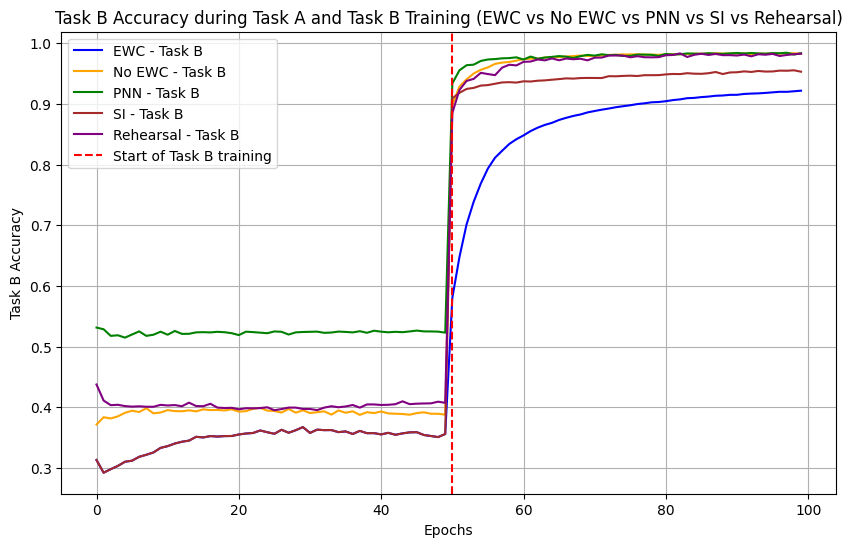

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean across runs for each method
task_B_ewc = np.mean(epoch_stats_5_test["ewc"]["val_task_B"], axis=0)  # Mean across runs for EWC
task_B_no_ewc = np.mean(epoch_stats_final["no_ewc"]["val_task_B"], axis=0)  # Mean across runs for No EWC
task_B_si = np.mean(epoch_stats_other_si_combined["si"]["val_acc_B"], axis=0)  # Mean across runs for SI
task_B_reh = np.mean(epoch_stats_other_reh_combined["reh"]["val_acc_B"], axis=0)  # Mean across runs for Rehearsal
task_B_pnn = np.mean(epoch_stats_other_pnn["pnn"]["val_acc_B"], axis=0)  # Mean across runs for PNN

# Compute the mean across runs for each method on Task B during training on Task A
task_B_during_A_ewc = np.mean(epoch_stats_5_test["Initial"]["task_B_during_A_val"], axis=0)
task_B_during_A_no_ewc = np.mean(epoch_stats_final["Initial"]["task_B_during_A_val"], axis=0)
task_B_during_A_si = np.mean(epoch_stats_other_si_combined["si"]["B_during_A_val"], axis=0)
task_B_during_A_reh = np.mean(epoch_stats_other_reh_combined["reh"]["B_during_A_val"], axis=0)
task_B_during_A_pnn = np.mean(epoch_stats_other_pnn_A["pnn"]["B_during_A"], axis=0)

task_B_pnn = task_B_pnn[:50]
#task_B_during_A_pnn_full = np.concatenate([task_B_during_A_pnn, task_B_during_A_pnn])


# Concatenate Task B accuracy for both phases: during Task A and during Task B training
ewc_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_ewc])
no_ewc_task_B_combined = np.concatenate([task_B_during_A_no_ewc, task_B_no_ewc])
pnn_task_B_combined = np.concatenate([task_B_during_A_pnn, task_B_pnn])
si_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_si])
reh_task_B_combined = np.concatenate([task_B_during_A_reh, task_B_reh])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot MAE for each method
# Plot Task B accuracy during training on Task B for each method
plt.plot(x_values, ewc_task_B_combined, label='EWC - Task B', color='blue')
plt.plot(x_values, no_ewc_task_B_combined, label='No EWC - Task B', color='orange')
plt.plot(x_values, pnn_task_B_combined, label='PNN - Task B', color='green')
plt.plot(x_values, si_task_B_combined, label='SI - Task B', color='brown')
plt.plot(x_values, reh_task_B_combined, label='Rehearsal - Task B', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(task_B_during_A_ewc), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Task B Accuracy')
plt.title('Task B Accuracy during Task A and Task B Training (EWC vs No EWC vs PNN vs SI vs Rehearsal)')
plt.legend()
plt.grid(True)

# Show the plot
#plt.savefig('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/TIL/Data/Bench/task_Bench_Task_B_During_A_and_B.png')
plt.show()


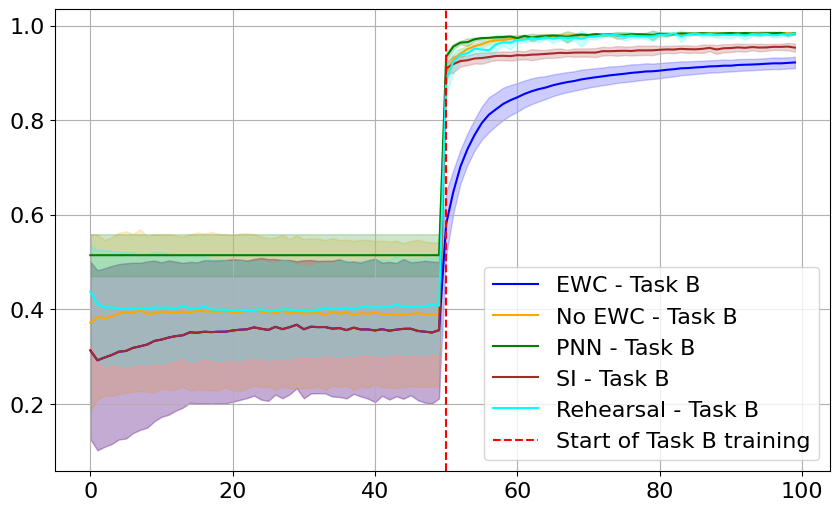

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean and standard deviation for Task B during Task B training
task_B_ewc = np.mean(epoch_stats_5_test["ewc"]["val_task_B"], axis=0)
task_B_ewc_std = np.std(epoch_stats_5_test["ewc"]["val_task_B"], axis=0)

task_B_no_ewc = np.mean(epoch_stats_final["no_ewc"]["val_task_B"], axis=0)
task_B_no_ewc_std = np.std(epoch_stats_final["no_ewc"]["val_task_B"], axis=0)

task_B_si = np.mean(epoch_stats_other_si_combined["si"]["val_acc_B"], axis=0)
task_B_si_std = np.std(epoch_stats_other_si_combined["si"]["val_acc_B"], axis=0)

task_B_reh = np.mean(epoch_stats_other_reh_combined["reh"]["val_acc_B"], axis=0)
task_B_reh_std = np.std(epoch_stats_other_reh_combined["reh"]["val_acc_B"], axis=0)

task_B_pnn = np.mean(epoch_stats_other_pnn["pnn"]["val_acc_B"], axis=0)
task_B_pnn_std = np.std(epoch_stats_other_pnn["pnn"]["val_acc_B"], axis=0)

# Truncate arrays for Task B training
task_B_pnn = task_B_pnn[:50]
task_B_pnn_std = task_B_pnn_std[:50]

# Compute the mean and standard deviation for Task B during Task A training
task_B_during_A_ewc = np.mean(epoch_stats_5_test["Initial"]["task_B_during_A_val"], axis=0)
task_B_during_A_ewc_std = np.std(epoch_stats_5_test["Initial"]["task_B_during_A_val"], axis=0)

task_B_during_A_no_ewc = np.mean(epoch_stats_final["Initial"]["task_B_during_A_val"], axis=0)
task_B_during_A_no_ewc_std = np.std(epoch_stats_final["Initial"]["task_B_during_A_val"], axis=0)

task_B_during_A_si = np.mean(epoch_stats_other_si_combined["si"]["B_during_A_val"], axis=0)
task_B_during_A_si_std = np.std(epoch_stats_other_si_combined["si"]["B_during_A_val"], axis=0)

task_B_during_A_reh = np.mean(epoch_stats_other_reh_combined["reh"]["B_during_A_val"], axis=0)
task_B_during_A_reh_std = np.std(epoch_stats_other_reh_combined["reh"]["B_during_A_val"], axis=0)

task_B_during_A_pnn = np.mean(epoch_stats_other_pnn["pnn"]["B_during_A"], axis=0)
task_B_during_A_pnn_std = np.std(epoch_stats_other_pnn["pnn"]["B_during_A"], axis=0)

# Repeat PNN Task B during Task A to match dimensions
task_B_during_A_pnn_full = np.concatenate([task_B_during_A_pnn, task_B_during_A_pnn])
task_B_during_A_pnn_full_std = np.concatenate([task_B_during_A_pnn_std, task_B_during_A_pnn_std])

# Concatenate Task B accuracy and standard deviations for both phases
ewc_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_ewc])
ewc_task_B_combined_std = np.concatenate([task_B_during_A_ewc_std, task_B_ewc_std])

no_ewc_task_B_combined = np.concatenate([task_B_during_A_no_ewc, task_B_no_ewc])
no_ewc_task_B_combined_std = np.concatenate([task_B_during_A_no_ewc_std, task_B_no_ewc_std])

pnn_task_B_combined = np.concatenate([task_B_during_A_pnn_full, task_B_pnn])
pnn_task_B_combined_std = np.concatenate([task_B_during_A_pnn_full_std, task_B_pnn_std])

si_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_si])
si_task_B_combined_std = np.concatenate([task_B_during_A_ewc_std, task_B_si_std])

reh_task_B_combined = np.concatenate([task_B_during_A_reh, task_B_reh])
reh_task_B_combined_std = np.concatenate([task_B_during_A_reh_std, task_B_reh_std])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

# Plot EWC with variance band
plt.plot(x_values, ewc_task_B_combined, label='EWC - Task B', color='blue')
plt.fill_between(x_values, ewc_task_B_combined - ewc_task_B_combined_std, ewc_task_B_combined + ewc_task_B_combined_std, color='blue', alpha=0.2)

# Plot No EWC with variance band
plt.plot(x_values, no_ewc_task_B_combined, label='No EWC - Task B', color='orange')
plt.fill_between(x_values, no_ewc_task_B_combined - no_ewc_task_B_combined_std, no_ewc_task_B_combined + no_ewc_task_B_combined_std, color='orange', alpha=0.2)

# Plot PNN with variance band
plt.plot(x_values, pnn_task_B_combined, label='PNN - Task B', color='green')
plt.fill_between(x_values, pnn_task_B_combined - pnn_task_B_combined_std, pnn_task_B_combined + pnn_task_B_combined_std, color='green', alpha=0.2)

# Plot SI with variance band
plt.plot(x_values, si_task_B_combined, label='SI - Task B', color='brown')
plt.fill_between(x_values, si_task_B_combined - si_task_B_combined_std, si_task_B_combined + si_task_B_combined_std, color='brown', alpha=0.2)

# Plot Rehearsal with variance band
plt.plot(x_values, reh_task_B_combined, label='Rehearsal - Task B', color='cyan')
plt.fill_between(x_values, reh_task_B_combined - reh_task_B_combined_std, reh_task_B_combined + reh_task_B_combined_std, color='cyan', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(task_B_during_A_ewc), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16)  
#plt.title('Task B Accuracy during Task A and Task B Training (EWC vs No EWC vs PNN vs SI vs Rehearsal)')
plt.legend(loc='lower right',fontsize=16)
plt.grid(True)

# Save and show the plot
plt.savefig('task_Bench_Task_B_During_A_and_B_with_variance_bigger.png')
plt.show()


In [29]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Define the transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Function to create a balanced subset
def create_balanced_subset(dataset, num_samples_per_class):
    class_indices = {i: [] for i in range(10)}  # Store indices for each class (0-9)

    # Sort dataset into classes
    for idx, (_, target) in enumerate(dataset):
        class_indices[target].append(idx)

    # Randomly select num_samples_per_class indices per class
    subset_indices = []
    for class_label, indices in class_indices.items():
        subset_indices.extend(np.random.choice(indices, num_samples_per_class, replace=False))

    # Create the subset
    subset = Subset(dataset, subset_indices)
    return subset

# Create a subset with 100 samples per digit
balanced_train_subset = create_balanced_subset(full_train_dataset, num_samples_per_class=1500)

# Use a DataLoader for the subset
train_loader = DataLoader(balanced_train_subset, batch_size=32, shuffle=True)

# Check the size of the subset
print(f"Subset size: {len(balanced_train_subset)}")


Subset size: 15000


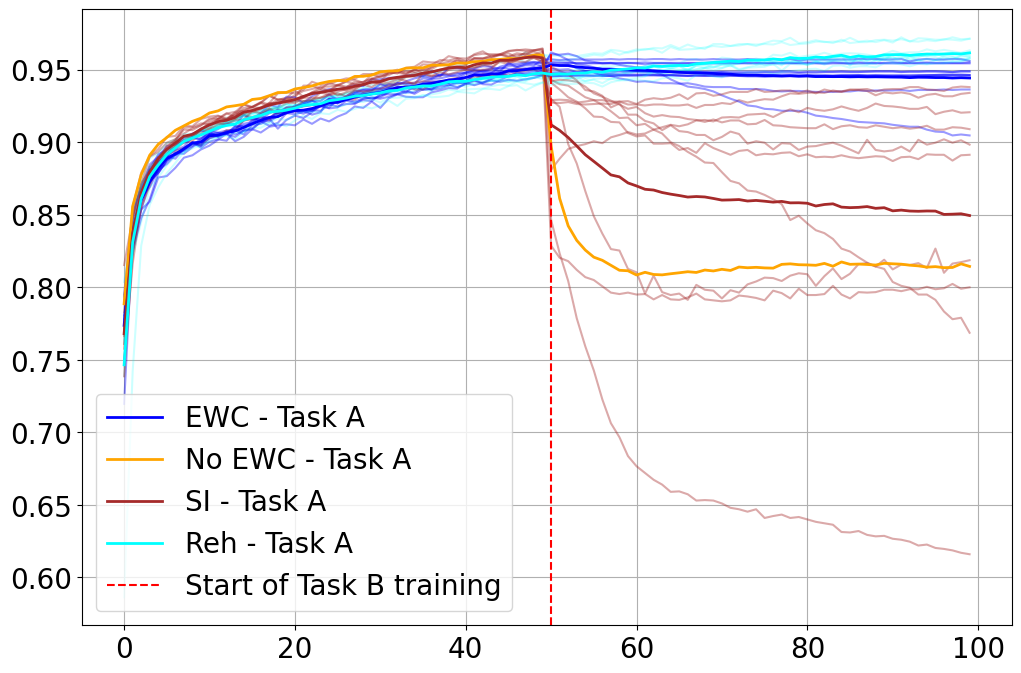

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Extract individual runs for each method
ewc_runs = np.array(epoch_stats_5_test["ewc"]["val_task_A_during_B"])  # Shape: (num_runs, num_epochs)
no_ewc_runs = np.array(epoch_stats_final["no_ewc"]["val_task_A_during_B"])
si_runs = np.array(epoch_stats_other_si_combined["si"]["val_task_A_during_B"])
reh_runs = np.array(epoch_stats_other_reh_combined["reh"]["val_task_A_during_B"])

# Extract initial phase performance (before Task B starts)
ewc_initial = np.array(epoch_stats_5_test["Initial"]["A_during_A_val"])
no_ewc_initial = np.array(epoch_stats_final["Initial"]["A_during_A_val"])
si_initial = np.array(epoch_stats_other_si_combined["si"]["A_during_A_val"])
reh_initial = np.array(epoch_stats_other_reh_combined["reh"]["A_during_A_val"])

# Concatenate initial phase with Task B phase for each run
ewc_full = np.concatenate([ewc_initial, ewc_runs], axis=1)  
no_ewc_full = np.concatenate([no_ewc_initial, no_ewc_runs], axis=1)
si_full = np.concatenate([si_initial, si_runs], axis=1)
reh_full = np.concatenate([reh_initial, reh_runs], axis=1)

# Define x-axis
total_epochs = ewc_full.shape[1]
x_values = np.arange(total_epochs)

plt.figure(figsize=(12, 8))

# Plot individual runs for each method
for i in range(ewc_full.shape[0]):  # Loop over 10 runs
    plt.plot(x_values, ewc_full[i], color='blue', alpha=0.4)
    #plt.plot(x_values, no_ewc_full[i], color='orange', alpha=0.2)
    plt.plot(x_values, si_full[i], color='brown', alpha=0.4)
    plt.plot(x_values, reh_full[i], color='cyan', alpha=0.2)

# Plot mean trends for clarity
plt.plot(x_values, np.mean(ewc_full, axis=0), color='blue', label='EWC - Task A', linewidth=2)
plt.plot(x_values, np.mean(no_ewc_full, axis=0), color='orange', label='No EWC - Task A', linewidth=2)
plt.plot(x_values, np.mean(si_full, axis=0), color='brown', label='SI - Task A', linewidth=2)
plt.plot(x_values, np.mean(reh_full, axis=0), color='cyan', label='Reh - Task A', linewidth=2)

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial[0]), color='red', linestyle='--', label='Start of Task B training')

# Formatting
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower left', fontsize=20)
plt.grid(True)

# Save and display the plot
plt.savefig('task_A_combined_accuracy_individual_runs.png')
plt.show()


In [60]:
import numpy as np
import pandas as pd

# Helper function to calculate max, min, mean, and 2 standard deviations for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_data = data[:, -1]  # Extract the last column (final epoch values)
    
    max_final = np.max(final_epoch_data)  # Max of the final epoch
    min_final = np.min(final_epoch_data)  # Min of the final epoch
    mean_final = np.mean(final_epoch_data)  # Mean of the final epoch
    std_final = np.std(final_epoch_data)  # Standard deviation of the final epoch
    upper_bound = mean_final + 2 * std_final  # 2 standard deviations above the mean
    lower_bound = mean_final - 2 * std_final  # 2 standard deviations below the mean
    
    return max_final, min_final, mean_final, upper_bound, lower_bound

# Extract final epoch statistics for Task A during Task B training
ewc_stats = calculate_final_epoch_stats_from_dict(epoch_stats_5_test["ewc"], "val_task_A_during_B")
no_ewc_stats = calculate_final_epoch_stats_from_dict(epoch_stats_final["no_ewc"], "val_task_A_during_B")
pnn_stats = calculate_final_epoch_stats_from_dict(epoch_stats_other_pnn["pnn"], "val_task_A_during_B")
si_stats = calculate_final_epoch_stats_from_dict(epoch_stats_other_si_combined["si"], "val_task_A_during_B")
reh_stats = calculate_final_epoch_stats_from_dict(epoch_stats_other_reh_combined["reh"], "val_task_A_during_B")

# Create a summary table for Task A during Task B training with 2 standard deviations range
final_epoch_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "PNN", "SI", "Rehearsal"],
    "Max Final MAE": [ewc_stats[0], no_ewc_stats[0], pnn_stats[0], si_stats[0], reh_stats[0]],
    "Min Final MAE": [ewc_stats[1], no_ewc_stats[1], pnn_stats[1], si_stats[1], reh_stats[1]],
    "Mean Final MAE": [ewc_stats[2], no_ewc_stats[2], pnn_stats[2], si_stats[2], reh_stats[2]],
    "Upper Bound (Mean + 2SD)": [ewc_stats[3], no_ewc_stats[3], pnn_stats[3], si_stats[3], reh_stats[3]],
    "Lower Bound (Mean - 2SD)": [ewc_stats[4], no_ewc_stats[4], pnn_stats[4], si_stats[4], reh_stats[4]]
})

# Extract the average final epoch MAE during Task A training for each method
avg_final_task_A_training = pd.DataFrame({
    "Method": ["EWC", "No EWC", "PNN", "SI", "Rehearsal"],
    "Avg Final Epoch MAE (Task A Training)": [
        np.mean(np.array(epoch_stats_final["Initial"]["A_during_A_val"])[:, -1]),
        np.mean(np.array(epoch_stats_final["Initial"]["A_during_A_val"])[:, -1]),
        np.mean(np.array(epoch_stats_other_pnn_A["pnn"]["A_during_A"])[:, -1]),
        np.mean(np.array(epoch_stats_other_si_combined["si"]["A_during_A_val"])[:, -1]),
        np.mean(np.array(epoch_stats_other_reh_combined["reh"]["A_during_A_val"])[:, -1])
    ]
})


# Display results
# Display results using print for both tables
print("Final Epoch Summary for Task A During Task B")
print(final_epoch_summary)

print("\nAvg Final Epoch MAE During Task A Training")
print(avg_final_task_A_training)



Final Epoch Summary for Task A During Task B
      Method  Max Final MAE  Min Final MAE  Mean Final MAE  \
0        EWC       0.956000       0.904667        0.944267   
1     No EWC       0.928333       0.631667        0.814400   
2        PNN       0.978583       0.970833        0.975491   
3         SI       0.938000       0.616000        0.849467   
4  Rehearsal       0.971333       0.956667        0.961600   

   Upper Bound (Mean + 2SD)  Lower Bound (Mean - 2SD)  
0                  0.972823                  0.915711  
1                  0.972103                  0.656697  
2                  0.980644                  0.970338  
3                  1.041476                  0.657457  
4                  0.971940                  0.951260  

Avg Final Epoch MAE During Task A Training
      Method  Avg Final Epoch MAE (Task A Training)
0        EWC                               0.960133
1     No EWC                               0.960133
2        PNN                               0.9

In [61]:
import numpy as np
import pandas as pd

# Helper function to calculate mean, max, min, and 2 standard deviations for the final epoch
def calculate_final_epoch_stats_task_B(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_data = data[:, -1]  # Extract the last column (final epoch values)
    
    mean_final = np.mean(final_epoch_data)  # Mean of the final epoch
    max_final = np.max(final_epoch_data)  # Max of the final epoch
    min_final = np.min(final_epoch_data)  # Min of the final epoch
    std_final = np.std(final_epoch_data)  # Standard deviation
    upper_bound = mean_final + 2 * std_final  # 2 standard deviations above mean
    lower_bound = mean_final - 2 * std_final  # 2 standard deviations below mean
    
    return mean_final, max_final, min_final, upper_bound, lower_bound

# Calculate stats for each method
task_B_ewc_stats = calculate_final_epoch_stats_task_B(epoch_stats_5_test["ewc"], "val_task_B")
task_B_no_ewc_stats = calculate_final_epoch_stats_task_B(epoch_stats_final["no_ewc"], "val_task_B")
task_B_si_stats = calculate_final_epoch_stats_task_B(epoch_stats_other_si_combined["si"], "val_acc_B")
task_B_reh_stats = calculate_final_epoch_stats_task_B(epoch_stats_other_reh_combined["reh"], "val_acc_B")
task_B_pnn_stats = calculate_final_epoch_stats_task_B(epoch_stats_other_pnn["pnn"], "val_acc_B")

# Create a summary table for Task B during Task B training with 2SD range
final_epoch_task_B_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "PNN", "SI", "Rehearsal"],
    "Mean Final Acc": [task_B_ewc_stats[0], task_B_no_ewc_stats[0], task_B_pnn_stats[0], task_B_si_stats[0], task_B_reh_stats[0]],
    "Max Final Acc": [task_B_ewc_stats[1], task_B_no_ewc_stats[1], task_B_pnn_stats[1], task_B_si_stats[1], task_B_reh_stats[1]],
    "Min Final Acc": [task_B_ewc_stats[2], task_B_no_ewc_stats[2], task_B_pnn_stats[2], task_B_si_stats[2], task_B_reh_stats[2]],
    "Upper Bound (Mean + 2SD)": [task_B_ewc_stats[3], task_B_no_ewc_stats[3], task_B_pnn_stats[3], task_B_si_stats[3], task_B_reh_stats[3]],
    "Lower Bound (Mean - 2SD)": [task_B_ewc_stats[4], task_B_no_ewc_stats[4], task_B_pnn_stats[4], task_B_si_stats[4], task_B_reh_stats[4]]
})


# Display results for Task B
print("Final Epoch Summary for Task B During Task B Training")
print(final_epoch_task_B_summary)


Final Epoch Summary for Task B During Task B Training
      Method  Mean Final Acc  Max Final Acc  Min Final Acc  \
0        EWC        0.922000       0.947000       0.907000   
1     No EWC        0.983200       0.986000       0.978000   
2        PNN        0.986176       0.988083       0.982250   
3         SI        0.953300       0.964667       0.936000   
4  Rehearsal        0.983067       0.986000       0.977667   

   Upper Bound (Mean + 2SD)  Lower Bound (Mean - 2SD)  
0                  0.946150                  0.897850  
1                  0.987492                  0.978908  
2                  0.989392                  0.982960  
3                  0.970752                  0.935848  
4                  0.988220                  0.977913  


In [64]:
# Combining the two dictionaries
epoch_stats_sensitivity = {}

for key in epoch_stats_sens_2.keys():
    epoch_stats_sensitivity[key] = {}
    for sub_key in epoch_stats_sens_2[key]:
        # Combine lists for each sub-key
        epoch_stats_sensitivity[key][sub_key] = epoch_stats_sens_2[key][sub_key] + epoch_stats_sens_3[key][sub_key] + epoch_stats_sens_4[key][sub_key] + epoch_stats_sens_5[key][sub_key]
        # + epoch_stats_sens_6[key][sub_key] + epoch_stats_sens_7[key][sub_key] + epoch_stats_sens_8[key][sub_key] + epoch_stats_sens_9[key][sub_key] + epoch_stats_sens_10[key][sub_key]
         

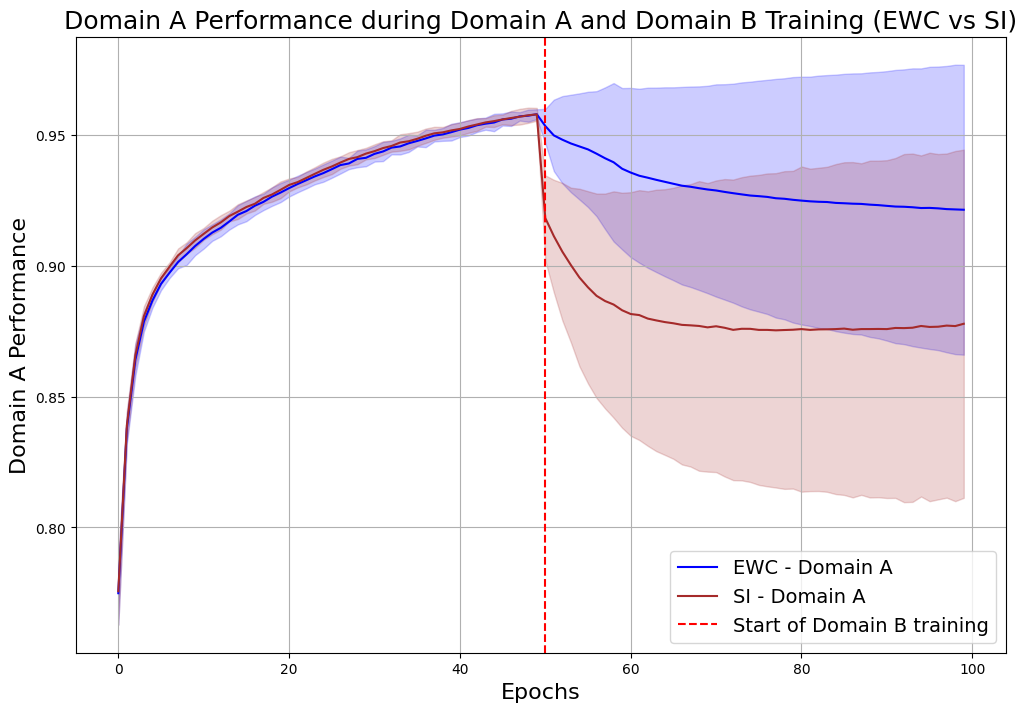

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean and standard deviation across all lambda values for EWC
ewc_initial_means = np.mean([np.mean(epoch_stats_sensitivity[lambda_val]["task_A"], axis=0) for lambda_val in epoch_stats_sensitivity], axis=0)
ewc_initial_stds = np.std([np.mean(epoch_stats_sensitivity[lambda_val]["task_A"], axis=0) for lambda_val in epoch_stats_sensitivity], axis=0)

ewc_task_A_during_B_means = np.mean([np.mean(epoch_stats_sensitivity[lambda_val]["task_A_during_B"], axis=0) for lambda_val in epoch_stats_sensitivity], axis=0)
ewc_task_A_during_B_stds = np.std([np.mean(epoch_stats_sensitivity[lambda_val]["task_A_during_B"], axis=0) for lambda_val in epoch_stats_sensitivity], axis=0)

# Compute mean and standard deviation across all lambda values for SI
si_initial_means = np.mean([np.mean(epoch_stats_sensitivity_si[lambda_val]["task_A"], axis=0) for lambda_val in epoch_stats_sensitivity_si], axis=0)
si_initial_stds = np.std([np.mean(epoch_stats_sensitivity_si[lambda_val]["task_A"], axis=0) for lambda_val in epoch_stats_sensitivity_si], axis=0)

si_task_A_during_B_means = np.mean([np.mean(epoch_stats_sensitivity_si[lambda_val]["task_A_during_B"], axis=0) for lambda_val in epoch_stats_sensitivity_si], axis=0)
si_task_A_during_B_stds = np.std([np.mean(epoch_stats_sensitivity_si[lambda_val]["task_A_during_B"], axis=0) for lambda_val in epoch_stats_sensitivity_si], axis=0)

# Concatenate Task A training and A_during_B for full trajectory
ewc_task_A_combined = np.concatenate([ewc_initial_means, ewc_task_A_during_B_means])
ewc_task_A_combined_stds = np.concatenate([ewc_initial_stds, ewc_task_A_during_B_stds])

si_task_A_combined = np.concatenate([si_initial_means, si_task_A_during_B_means])
si_task_A_combined_stds = np.concatenate([si_initial_stds, si_task_A_during_B_stds])

# Define x-axis values
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(12, 8))

# Plot EWC mean performance with variance bands
plt.plot(x_values, ewc_task_A_combined, label='EWC - Domain A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined - 2 * ewc_task_A_combined_stds, ewc_task_A_combined + 2 * ewc_task_A_combined_stds, color='blue', alpha=0.2)

# Plot SI mean performance with variance bands
plt.plot(x_values, si_task_A_combined, label='SI - Domain A', color='brown')
plt.fill_between(x_values, si_task_A_combined - 2 * si_task_A_combined_stds, si_task_A_combined + 2 * si_task_A_combined_stds, color='brown', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_means), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Domain A Performance', fontsize=16)
plt.title('Domain A Performance during Domain A and Domain B Training (EWC vs SI)', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)

# Display the plot
plt.show()


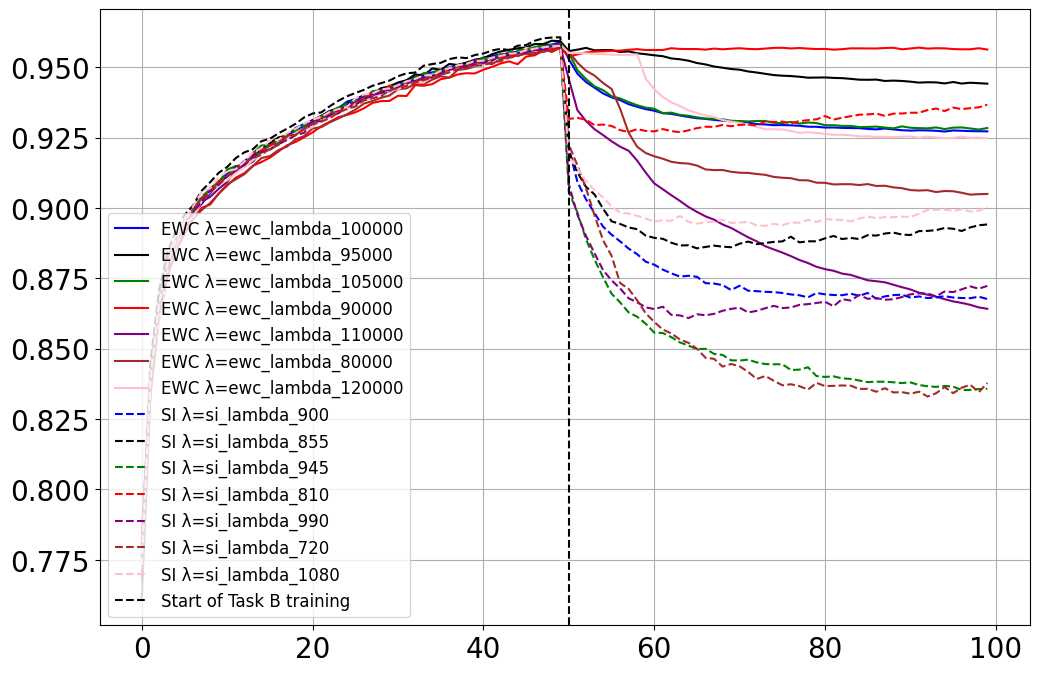

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for different lambda values
colors = [
    "blue", "black", "green", "red", "purple", "brown", "pink", "gray","cyan"
]

# Extract lambda values
lambda_values_ewc = list(epoch_stats_sensitivity.keys())
lambda_values_si = list(epoch_stats_sensitivity_si.keys())

# Define x-axis values (assuming all runs have the same number of epochs)
total_epochs_ewc = len(epoch_stats_sensitivity[lambda_values_ewc[0]]["task_A"][0]) + \
                   len(epoch_stats_sensitivity[lambda_values_ewc[0]]["task_A_during_B"][0])
total_epochs_si = len(epoch_stats_sensitivity_si[lambda_values_si[0]]["task_A"][0]) + \
                  len(epoch_stats_sensitivity_si[lambda_values_si[0]]["task_A_during_B"][0])

x_values_ewc = np.arange(total_epochs_ewc)
x_values_si = np.arange(total_epochs_si)

plt.figure(figsize=(12, 8))

# Plot each lambda experiment for EWC
for idx, lambda_val in enumerate(lambda_values_ewc):
    ewc_initial_means = np.mean(epoch_stats_sensitivity[lambda_val]["task_A"], axis=0)
    ewc_task_A_during_B_means = np.mean(epoch_stats_sensitivity[lambda_val]["task_A_during_B"], axis=0)
    ewc_task_A_combined = np.concatenate([ewc_initial_means, ewc_task_A_during_B_means])

    plt.plot(x_values_ewc, ewc_task_A_combined, label=f'EWC λ={lambda_val}', color=colors[idx])

# Plot each lambda experiment for SI
for idx, lambda_val in enumerate(lambda_values_si):
    si_initial_means = np.mean(epoch_stats_sensitivity_si[lambda_val]["task_A"], axis=0)
    si_task_A_during_B_means = np.mean(epoch_stats_sensitivity_si[lambda_val]["task_A_during_B"], axis=0)
    si_task_A_combined = np.concatenate([si_initial_means, si_task_A_during_B_means])

    plt.plot(x_values_si, si_task_A_combined, label=f'SI λ={lambda_val}', color=colors[idx], linestyle="dashed")

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_means), color='black', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower left',fontsize=12)
#plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(1, 0))
plt.grid(True)
#plt.savefig('til_bench_sensitivity_analysis.png')
# Display the plot
plt.show()


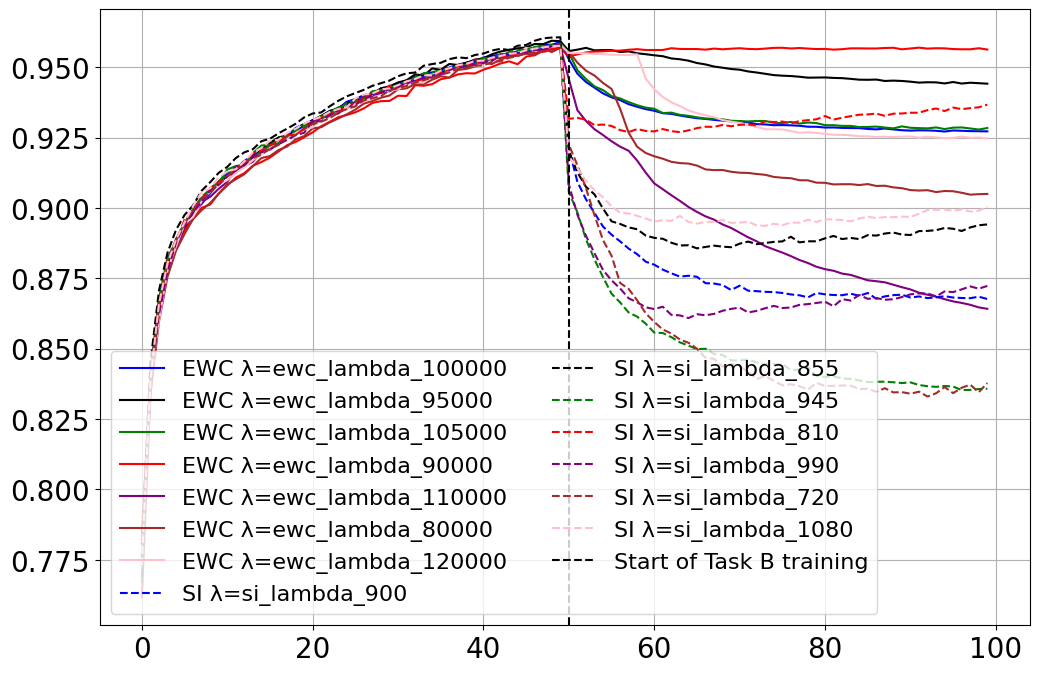

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for different lambda values
colors = [
    "blue", "black", "green", "red", "purple", "brown", "pink", "gray", "cyan"
]

# Extract lambda values
lambda_values_ewc = list(epoch_stats_sensitivity.keys())
lambda_values_si = list(epoch_stats_sensitivity_si.keys())

# Define x-axis values (assuming all runs have the same number of epochs)
total_epochs_ewc = len(epoch_stats_sensitivity[lambda_values_ewc[0]]["task_A"][0]) + \
                   len(epoch_stats_sensitivity[lambda_values_ewc[0]]["task_A_during_B"][0])
total_epochs_si = len(epoch_stats_sensitivity_si[lambda_values_si[0]]["task_A"][0]) + \
                  len(epoch_stats_sensitivity_si[lambda_values_si[0]]["task_A_during_B"][0])

x_values_ewc = np.arange(total_epochs_ewc)
x_values_si = np.arange(total_epochs_si)

plt.figure(figsize=(12, 8))

# Plot each lambda experiment for EWC
for idx, lambda_val in enumerate(lambda_values_ewc):
    ewc_initial_means = np.mean(epoch_stats_sensitivity[lambda_val]["task_A"], axis=0)
    ewc_task_A_during_B_means = np.mean(epoch_stats_sensitivity[lambda_val]["task_A_during_B"], axis=0)
    ewc_task_A_combined = np.concatenate([ewc_initial_means, ewc_task_A_during_B_means])

    plt.plot(x_values_ewc, ewc_task_A_combined, label=f'EWC λ={lambda_val}', color=colors[idx])

# Plot each lambda experiment for SI
for idx, lambda_val in enumerate(lambda_values_si):
    si_initial_means = np.mean(epoch_stats_sensitivity_si[lambda_val]["task_A"], axis=0)
    si_task_A_during_B_means = np.mean(epoch_stats_sensitivity_si[lambda_val]["task_A_during_B"], axis=0)
    si_task_A_combined = np.concatenate([si_initial_means, si_task_A_during_B_means])

    plt.plot(x_values_si, si_task_A_combined, label=f'SI λ={lambda_val}', color=colors[idx], linestyle="dashed")

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_means), color='black', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Increase the font size and set the legend in two columns
plt.legend(loc='lower left', fontsize=16, ncol=2)


plt.grid(True)
plt.savefig('til_bench_sensitivity_analysis.png')

# Display the plot
plt.show()


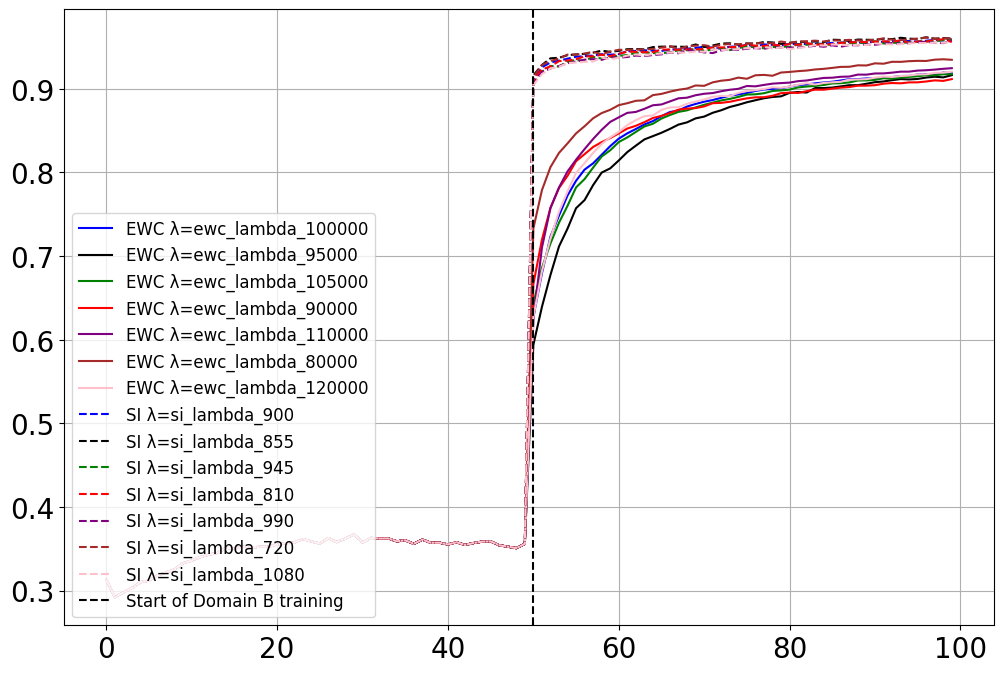

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for different lambda values
colors = [
    "blue", "black", "green", "red", "purple", "brown", "pink", "gray", "cyan"
]

# Extract lambda values
lambda_values_ewc = list(epoch_stats_sensitivity.keys())
lambda_values_si = list(epoch_stats_sensitivity_si.keys())

# Define x-axis values (assuming all runs have the same number of epochs)
total_epochs_ewc = len(task_B_during_A_ewc) + \
                   len(epoch_stats_sensitivity[lambda_values_ewc[0]]["task_B"][0])
total_epochs_si = len(task_B_during_A_ewc) + \
                  len(epoch_stats_sensitivity_si[lambda_values_si[0]]["task_B"][0])

x_values_ewc = np.arange(total_epochs_ewc)
x_values_si = np.arange(total_epochs_si)

plt.figure(figsize=(12, 8))

# Plot each lambda experiment for EWC
for idx, lambda_val in enumerate(lambda_values_ewc):
    ewc_task_B_during_A_means = task_B_during_A_ewc  # Use provided mean values
    ewc_task_B_means = np.mean(epoch_stats_sensitivity[lambda_val]["task_B"], axis=0)
    ewc_task_B_combined = np.concatenate([ewc_task_B_during_A_means, ewc_task_B_means])

    plt.plot(x_values_ewc, ewc_task_B_combined, label=f'EWC λ={lambda_val}', color=colors[idx])

# Plot each lambda experiment for SI
for idx, lambda_val in enumerate(lambda_values_si):
    si_task_B_during_A_means = task_B_during_A_ewc  # Use same values for SI
    si_task_B_means = np.mean(epoch_stats_sensitivity_si[lambda_val]["task_B"], axis=0)
    si_task_B_combined = np.concatenate([si_task_B_during_A_means, si_task_B_means])

    plt.plot(x_values_si, si_task_B_combined, label=f'SI λ={lambda_val}', color=colors[idx], linestyle="dashed")

# Mark the point where Task B training begins
plt.axvline(x=len(task_B_during_A_ewc), color='black', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower left', fontsize=12)
plt.grid(True)

# Save and display the plot
plt.savefig('til_bench_sensitivity_analysis_taskB.png')
plt.show()
